In [1]:
from text_loader_utils import TextLoader
import cPickle
import numpy as np
import tensorflow as tf
from variational_model import Variational_Document_Model
import os
from vector_utils import find_norm
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)


def xavier_init(fan_in , fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     fan_in = in_and_out[0]
#     fan_out = in_and_out[1]
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)


In [7]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train')   
data_ = twenty_train.data
print "Download 20 news group data completed"
A = TextLoader(data_)
batch_size = 100

sess = tf.InteractiveSession()
vae = Variational_Document_Model(sess , len(A.vocab), 50, [500 , 500] ,  
                         transfer_fct=tf.nn.relu , output_activation=tf.nn.softmax,
                         batch_size=100, initializer=xavier_init , mode = 'gather'   )

vae.load('save_my_model')

In [4]:

############## This is the hidden ----> output matrix which capture the word embedding ( H x V [ hidden_dim x Vocab])
embedding_matrix = vae.sess.run(vae.Weights_generator['out_mean'])
embedding_matrix = R.transpose()
embedding_matrix = find_norm(embedding_matrix) ####### Normalizing the matrix helps to find cosine similarity so fast 

In [ ]:
from vector_utils import find_similar
def word_match(norm_mat , word_ , vocab, vocab_inverse , topN = 10):
    
    idx = vocab[word_]
    similarity_meas , indexes = find_similar(norm_mat , norm_mat[idx])
    words = [vocab_inverse[i_x_] for i_x_ in indexes[:topN]]
    return zip(words , similarity_meas[:topN])


In [11]:
######## Similar words for ######


#### weapons

In [ ]:
[('weapons', 0.99999988),   
 ('weapon', 0.7657035),
 ('guns', 0.70421934),
 ('armed', 0.69408774),
 ('gun', 0.68413383),
 ('military', 0.66630989),
 ('army', 0.65324694),
 ('rights', 0.57042903),
 ('troops', 0.56965572),
 ('arms', 0.56932634)]

#### medical

In [ ]:
[('medical', 0.99999994),
 ('medicine', 0.70563364),
 ('patients', 0.66827065),
 ('treatment', 0.64965975),
 ('hospital', 0.61918598),
 ('patient', 0.57656151),
 ('studies', 0.57353866),
 ('health', 0.56748629),
 ('diagnosed', 0.55950201),
 ('diseases', 0.53943944)]

#### companies

In [ ]:
[('companies', 1.0000001),
 ('company', 0.58046353),
 ('buy', 0.55324298),
 ('expensive', 0.53670096),
 ('cheaper', 0.52318913),
 ('money', 0.51446158),
 ('technology', 0.50169706),
 ('product', 0.49790773),
 ('educational', 0.47482941),
 ('prices', 0.47426319)]

#### define

In [ ]:
[('define', 1.0000002),
 ('defined', 0.63695252),
 ('essential', 0.57924092),
 ('example', 0.5755744),
 ('simple', 0.57412481),
 ('false', 0.56581116),
 ('correct', 0.56372005),
 ('words', 0.5620147),
 ('depends', 0.5610252),
 ('similarly', 0.54098994)]

#### isarael

In [ ]:
[('israel', 0.99999988),
 ('israeli', 0.75067234),
 ('arabs', 0.70044887),
 ('jews', 0.65153724),
 ('palestine', 0.6349805),
 ('lebanese', 0.6330421),
 ('arab', 0.62311369),
 ('peace', 0.60640955),
 ('jerusalem', 0.59816843),
 ('palestinian', 0.59430242)]

#### book

In [ ]:
[('book', 1.0),
 ('books', 0.7720589),
 ('little', 0.68587965),
 ('basic', 0.67432868),
 ('new', 0.67332816),
 ('world', 0.66897786),
 ('read', 0.66883802),
 ('based', 0.66325933),
 ('look', 0.65879941),
 ('reading', 0.65650195)]

In [16]:
############ Mapping the hidden dimension of 20 news dataset to Tsne for visualization

In [ ]:

################# Pickup the hidden dimensions for all 20 news groups
batch_size = 100
H_20_grp_nws = []
batch_data = A.get_batch(batch_size)
for batch_ in batch_data:

        collected_data = [chunks for chunks in batch_]
        ##### Here batch_xs ( Bag of words with count of words)
        ##### Here mask_xs  ( Bag of words with 1 at the index of words in doc , no counts)
        ##### Here mask_negative is not using ( Tried with negative sampling )
        batch_xs , mask_xs , mask_negative  = A._bag_of_words(collected_data)
        ###### Here batch_flattened gives position of words in all documents into one array
        ###### because gather_nd does not support gradients . So , we have to use tf.gather
        batch_flattened = np.ravel(batch_xs)
        index_positions = np.where( batch_flattened > 0 )[0]
        
        # Fit training using batch data
        h_batch = vae.sess.run(vae.z, feed_dict={vae.x:find_norm(batch_xs) , vae.dynamic_batch_size:mask_xs.shape[0]})
        H_20_grp_nws.extend(h_batch)

H_20_grp_nws = np.array(H_20_grp_nws)
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
%time H_tsne = tsne.fit_transform(H_20_grp_nws) ########### Converting to tsne

############ Picking only non - null values after pre-processing ( The non null indexes of data is in self.data_index)
newsgroups_target = [newsgroups_train.target[i] for i in A.data_index]
########### Converting targets to One-hot-K Vectors by tf.one_hot for visualization purposes
news_target_one_hot = sess.run(tf.one_hot(newsgroups_target , depth=len(set(newsgroups_target))))



plt.figure(figsize=(8, 6)) 
plt.scatter(H_tsne[:, 0], H_tsne[:, 1], c=np.argmax(news_target_one_hot, 1))
plt.colorbar()



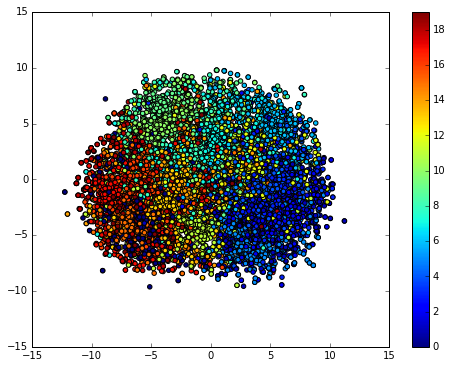

In [19]:
from IPython.display import Image
Image(filename='20newstsne.png')